In [70]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, make_axis_great_again, plot_epochs

In [72]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '29.04_06.05_scaling-up'

= found 40 / 40 training / validation epochs
- plotted metrics [11.7, 17.7] in epochs [0, 39]
- plotted metrics [23.7, 26.5] in epochs [0, 39]
= found 43 / 43 training / validation epochs
- plotted metrics [11.1, 15.1] in epochs [0, 42]
- plotted metrics [23.3, 27.5] in epochs [0, 42]


Text(0.5, 0.98, 'Algebraic, PRE-TRAINED BB (optimizing just alg_confidences, deconv_layers and final_layer), lr=1e-6 on 11872 / 703 images ~ 384 x 384 pixels')

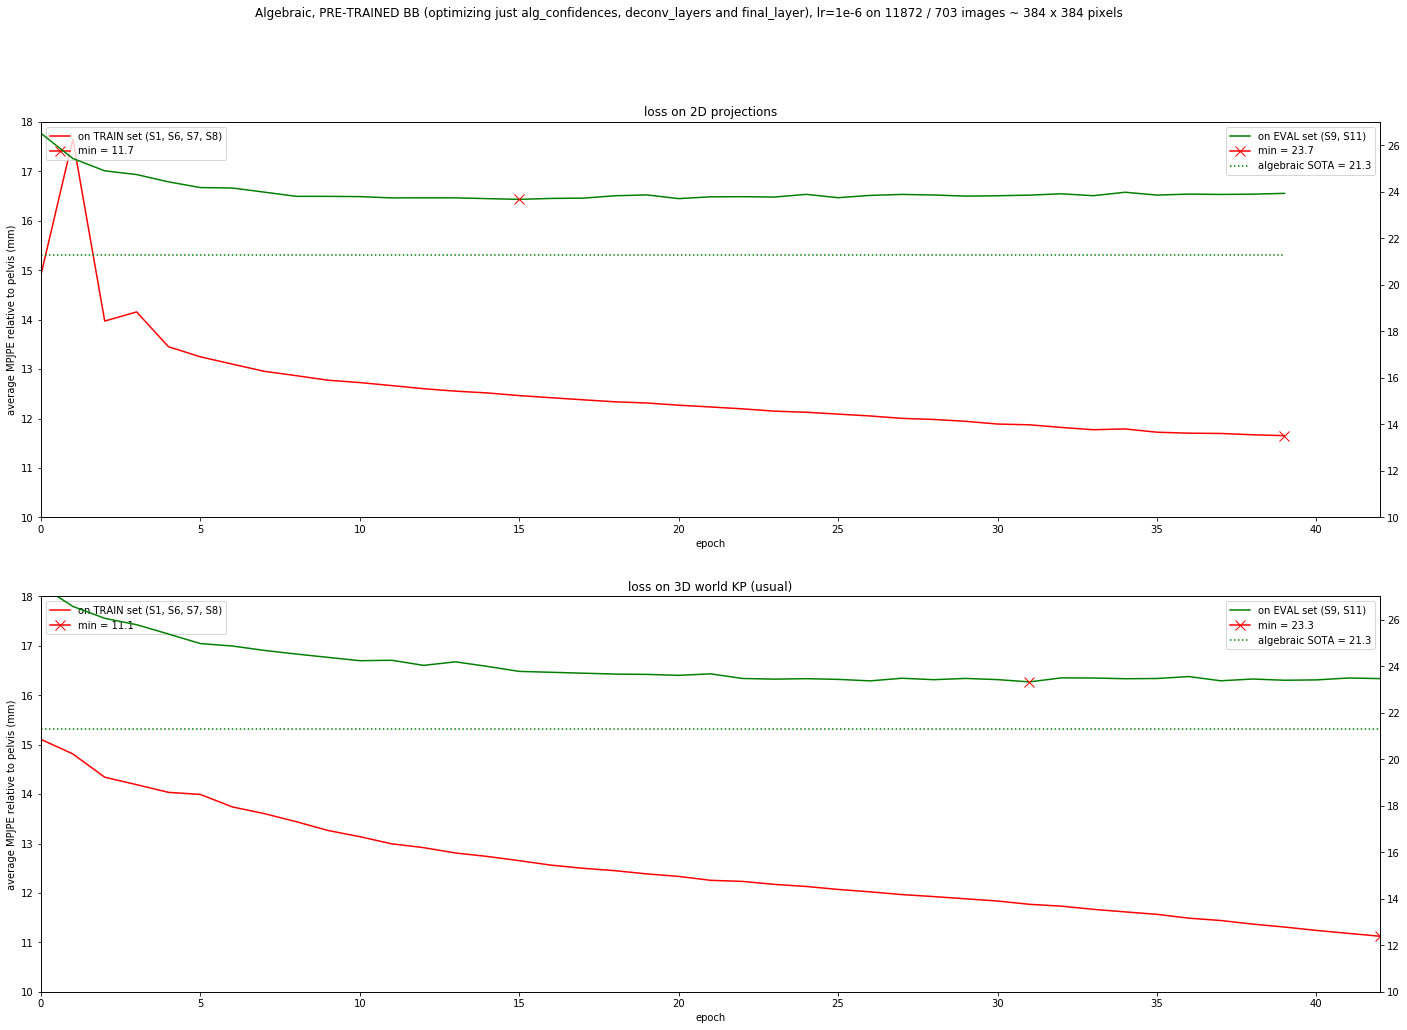

In [75]:
fig, axis = get_figa(2, 1, heigth=8, width=24)

train_ylim = [10, 18]
eval_ylim = [10, 27]

train_metrics, eval_metrics = parse_metrics_log(current_milestone / '2d.txt')
ax = axis.ravel()[0]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)
make_axis_great_again(
    ax,
    title='loss on 2D projections',
    left_title='average MPJPE relative to pelvis (mm)',
    xlim=[0, 42],
    ylim=train_ylim
)
ax.grid(False)

train_metrics, eval_metrics = parse_metrics_log(current_milestone / '3d.txt')
ax = axis.ravel()[1]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)
make_axis_great_again(
    ax,
    title='loss on 3D world KP (usual)',
    left_title='average MPJPE relative to pelvis (mm)',
    xlim=[0, 42],
    ylim=train_ylim
)
ax.grid(False)

fig.suptitle('Algebraic, PRE-TRAINED BB (optimizing just alg_confidences, deconv_layers and final_layer), lr=1e-6 on 11872 / 703 images ~ 384 x 384 pixels')
# long_optim_2d_VS_3d.png

human36m_alg_AlgebraicTriangulationNet@30.04.2021-18:57:01 correctly parsed
training on 12, evaluating on 5
found 1000 epochs
training loss in [2.2, 1735.9]
training metrics in [144.9, 1076961.8]
eval metrics in [198.2, 2070798.0]
- plotted metrics [2.2, 1735.9] in epochs [0, 999]
- plotted metrics [144.9, 1076961.8] in epochs [0, 999]
- plotted metrics [198.2, 2070798.0] in epochs [0, 999]


Text(0.5, 0.98, 'cam2cam estimation (12 training / 5 validation images), using 2D GT projections, lr=1e-6')

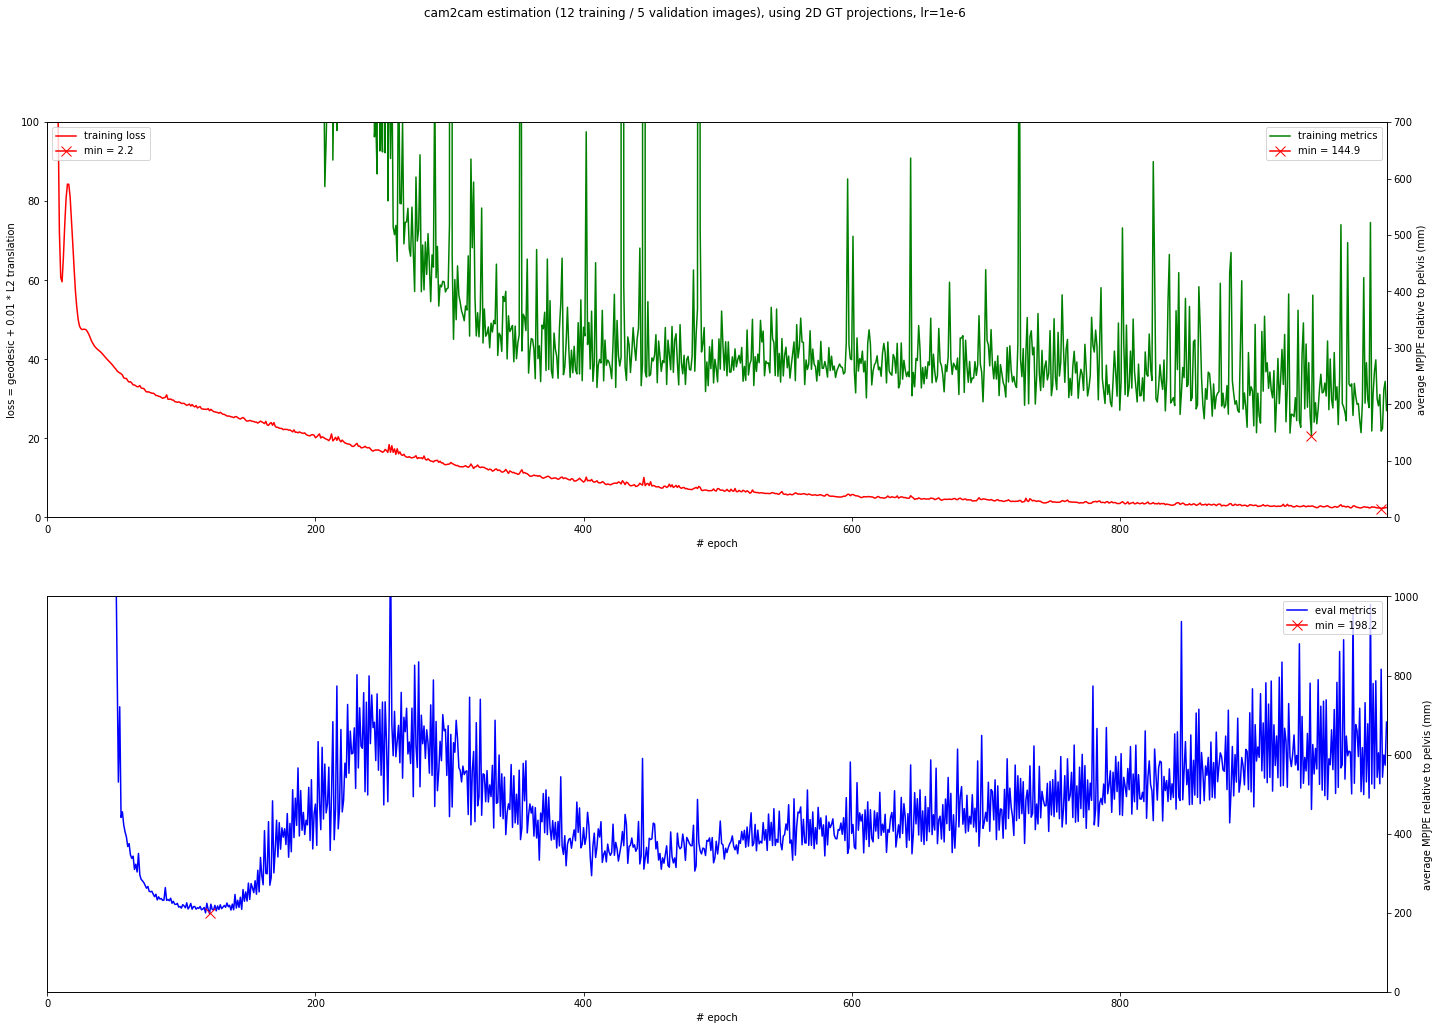

In [84]:
exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '14524206.out')
fig, axis = get_figa(2, 1, heigth=8, width=24)

plot_epochs(
    axis, epochs,
    train_metric_ylim=[0, 700],
    eval_metric_ylim=[0, 1000],
    loss_ylim=[0, 100],
    loss_ylabel='loss = geodesic + 0.01 * L2 translation',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)

fig.suptitle('cam2cam estimation (12 training / 5 validation images), using 2D GT projections, lr=1e-6')
# full_cam2cam.png